## Figure 10 - 1D Corner Plot
This Jupyter notebooks reproduces Figure 10. The output .png and .pdf files are saved in <em>/figures</em>. Marginalized distributions (corner plot) from the 1D retrieval on the 1D simulated data set to verify the retrieval algorithm can retrieve the correct 1D input parameters. 

In [1]:
%matplotlib inline
import os
import corner
import pymultinest
import numpy as np
import sys
import json
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import os
import re

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
params_unit = {
    "logH2O" : '',
    "logCO" : '',
    "T0" : 'K',
    "logP1" : 'bar',
    "logP2" : 'bar',
    "logP3" : 'bar',
    "a1" : '',
    "a2" : '',
    "Kp" : 'km/s',
    "vsys" : 'km/s',
    "loga" : '',
    "dphi" : '',
    'vbroad' : 'km/s'
}
    
params_label = {
    "logH2O" : "\n"r"$\log{X_{\rm{H_2O}}}$""\n",
    "logCO" : "\n"r"$\log{X_{\rm{CO}}}$""\n",
    "T0" : "\n"r"$T_{\rm{0}}$""\n",
    "logP1" : "\n"r"$\log{P_{\rm{1}}}$""\n",
    "logP2" : "\n"r"$\log{P_{\rm{2}}}$""\n",
    "logP3" : "\n"r"$\log{P_{\rm{3}}}$""\n",
    "a1" : "\n"r"$\alpha_{\rm{1}}$""\n",
    "a2" : "\n"r"$\alpha_{\rm{2}}$""\n",
    "Kp" : "\n"r"$\Delta K_{\rm{p}}$""\n",
    "vsys" : "\n"r"$\Delta v_{\rm{sys}}$""\n",
    "loga" : "\n"r"$\log{a}$""\n",
    "dphi" : "\n"r"$\Delta \phi$""\n",
    "vbroad" : "\n"r"$\delta v_{\rm{broad}}$""\n",
}


params_precision = {
    "logH2O" : 1,
    "logCO" : 1,
    "T0" : 0,
    "logP1" : 1,
    "logP2" : 1,
    "logP3" : 1,
    "a1" : 2,
    "a2" : 2,
    "Kp" : 1,
    "vsys" : 1,
    "loga" : 2,
    "dphi" : 2,
    "vbroad" : 1
}

# MS09 TP profile for plotting
def TP_MS(P, T0, P1, P2, P3, a1, a2, beta=0.5, Tmin=500., Tmax=5000.):
    """
    TP-parameterisation from Madhusudhan & Seager 2009.

    Input parameters:
    P = pressure array in order of high to low pressures
    T0, P1, P2, P3, a1, a2, beta = see paper
    Tmin = minimum temperature, prevent profiles from becoming too cold

    Output parameters:
    T = temperature array
    """
    #P = P[::-1] # reverse array to be low -> high pressure
    nlayers = P.shape[0] # nlayers
    Tarr = np.zeros(nlayers) # allocate memory for temperature array
    P0 = P[0] # first pressure point

    # Layer 1
    Tarr1 = (np.log(P/P0)/a1)**(1./beta)+T0
    Tarr[P < P1] = Tarr1[P < P1]

    # Layer 2
    T2 = (np.log(P1/P0)/a1)**(1./beta)+T0-(np.log(P1/P2)/a2)**(1./beta)
    Tarr2 = (np.log(P/P2)/a2)**(1./beta)+T2
    Tarr[P >= P1] = Tarr2[P >= P1]

    # Layer 3
    Tarr[P >= P3] = Tarr2[P >= P3][0]

    # Some boundary conditions
    Tarr[Tarr <= Tmin] = Tmin
    Tarr[Tarr >= Tmax] = Tmax
    return Tarr

def plot_pt_profile(ax):
    NN = 1000
    draws = np.random.randint(len(samples), size=NN)
    xrand = samples[draws, :]
    Tarr = []
    logP = np.arange(-5., 2.5, 0.08)+0.08
    P = 10.0**logP
    ticksize=32

    for i in range(NN):
        x = xrand[i, :]
        _, _, T0, logP1, logP2, logP3, a1, a2, kp, vsys = x
        T = TP_MS(P, T0, 10**logP1, 10**logP2, 10**logP3, a1, a2)
        Tarr = np.concatenate([Tarr, T])

    Tarr = Tarr.reshape(NN, P.shape[0])
    Tmedian = np.zeros(P.shape[0])
    Tlow_1sig = np.zeros(P.shape[0])
    Thigh_1sig = np.zeros(P.shape[0])
    Tlow_2sig = np.zeros(P.shape[0])
    Thigh_2sig = np.zeros(P.shape[0])

    for i in range(P.shape[0]):
        percentiles = np.percentile(Tarr[:, i], [4.55, 15.9, 50, 84.1, 95.45])
        Tlow_2sig[i] = percentiles[0]
        Tlow_1sig[i] = percentiles[1]
        Tmedian[i] = percentiles[2]
        Thigh_1sig[i] = percentiles[3]
        Thigh_2sig[i] = percentiles[4]

    #np.save(os.path.join(dirout, 'pt_constraints_run_{}.npy'.format(run)), [P, Tlow_2sig, Tlow_1sig, Tmedian, Thigh_1sig, Thigh_2sig])
    plt.fill_betweenx(P, Tlow_1sig, Thigh_1sig, facecolor=color,
                  edgecolor='None', alpha=0.5, label=r'1$\sigma$')
    plt.fill_betweenx(P, Tlow_2sig, Thigh_2sig, facecolor=color,
                  edgecolor='None', alpha=0.25, label=r'2$\sigma$')
    ax.axis([500, 4000, 30, 1E-5])
    ax.set_xticks([0, 1000, 2000, 3000, 4000, 5000])
    plt.semilogy()
    ax.plot(Tmedian, P, color='k', lw=2)

    p = [2250, -4, -1, 1, 0.5, 0.25]
    Texp = TP_MS(P, p[0], 10**p[1], 10**p[2], 10**p[3], p[4], p[5])
    plt.plot(Texp, P, color='k', label='Input forward model', lw=2, ls='--')


    plt.xlabel('Temperature [K]', size=labelsize)
    plt.ylabel('Pressure [bar]', size=labelsize)
    plt.tick_params(length=10, width=1, labelsize=ticksize*1., which='major')
    plt.minorticks_on()
    plt.xlim(0,5000)
    plt.ylim(10**2.5, 1e-6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax

In [2]:
dirin = os.path.abspath('../data/pmn_out_1D_on_1D')
prefix=dirin+'/template_'

params = json.load(open(prefix+'params.json'))
ndim = len(params)

sigma_levels=[1,2]
plot_ranges=None
add_legend=True
labelsize=36
ticksize=32

a = pymultinest.Analyzer(n_params=ndim, outputfiles_basename=prefix, verbose=False)
weights = a.get_data()[:,0]
mask = weights > 1e-5

data = a.get_data()[:,2:]

labels = [params_label[p] for p in params]
units = [params_unit[p] for p in params]

plot_ranges =[(-7,-2),(-7,-2),(1500,4000),(-5.,-2),(-2.,1.),(0.,2.),
              (0.1,1.),(0.2,0.35),(-10,10),(-10,10), (0,10)]
expected_values = [-3.5, -4.5, 2250, -4, -1, 1, 0.5, 0.25, 0, 0, 0, 0, 0.]

color='tab:green'

/var/folders/fr/d4gym27d0y1dw670nr2vpn5c0000gr/T/ipykernel_26068/3616688083.py:40: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.ticker.NullLocator'>
  ax.locator_params(axis='both', nbins=3)


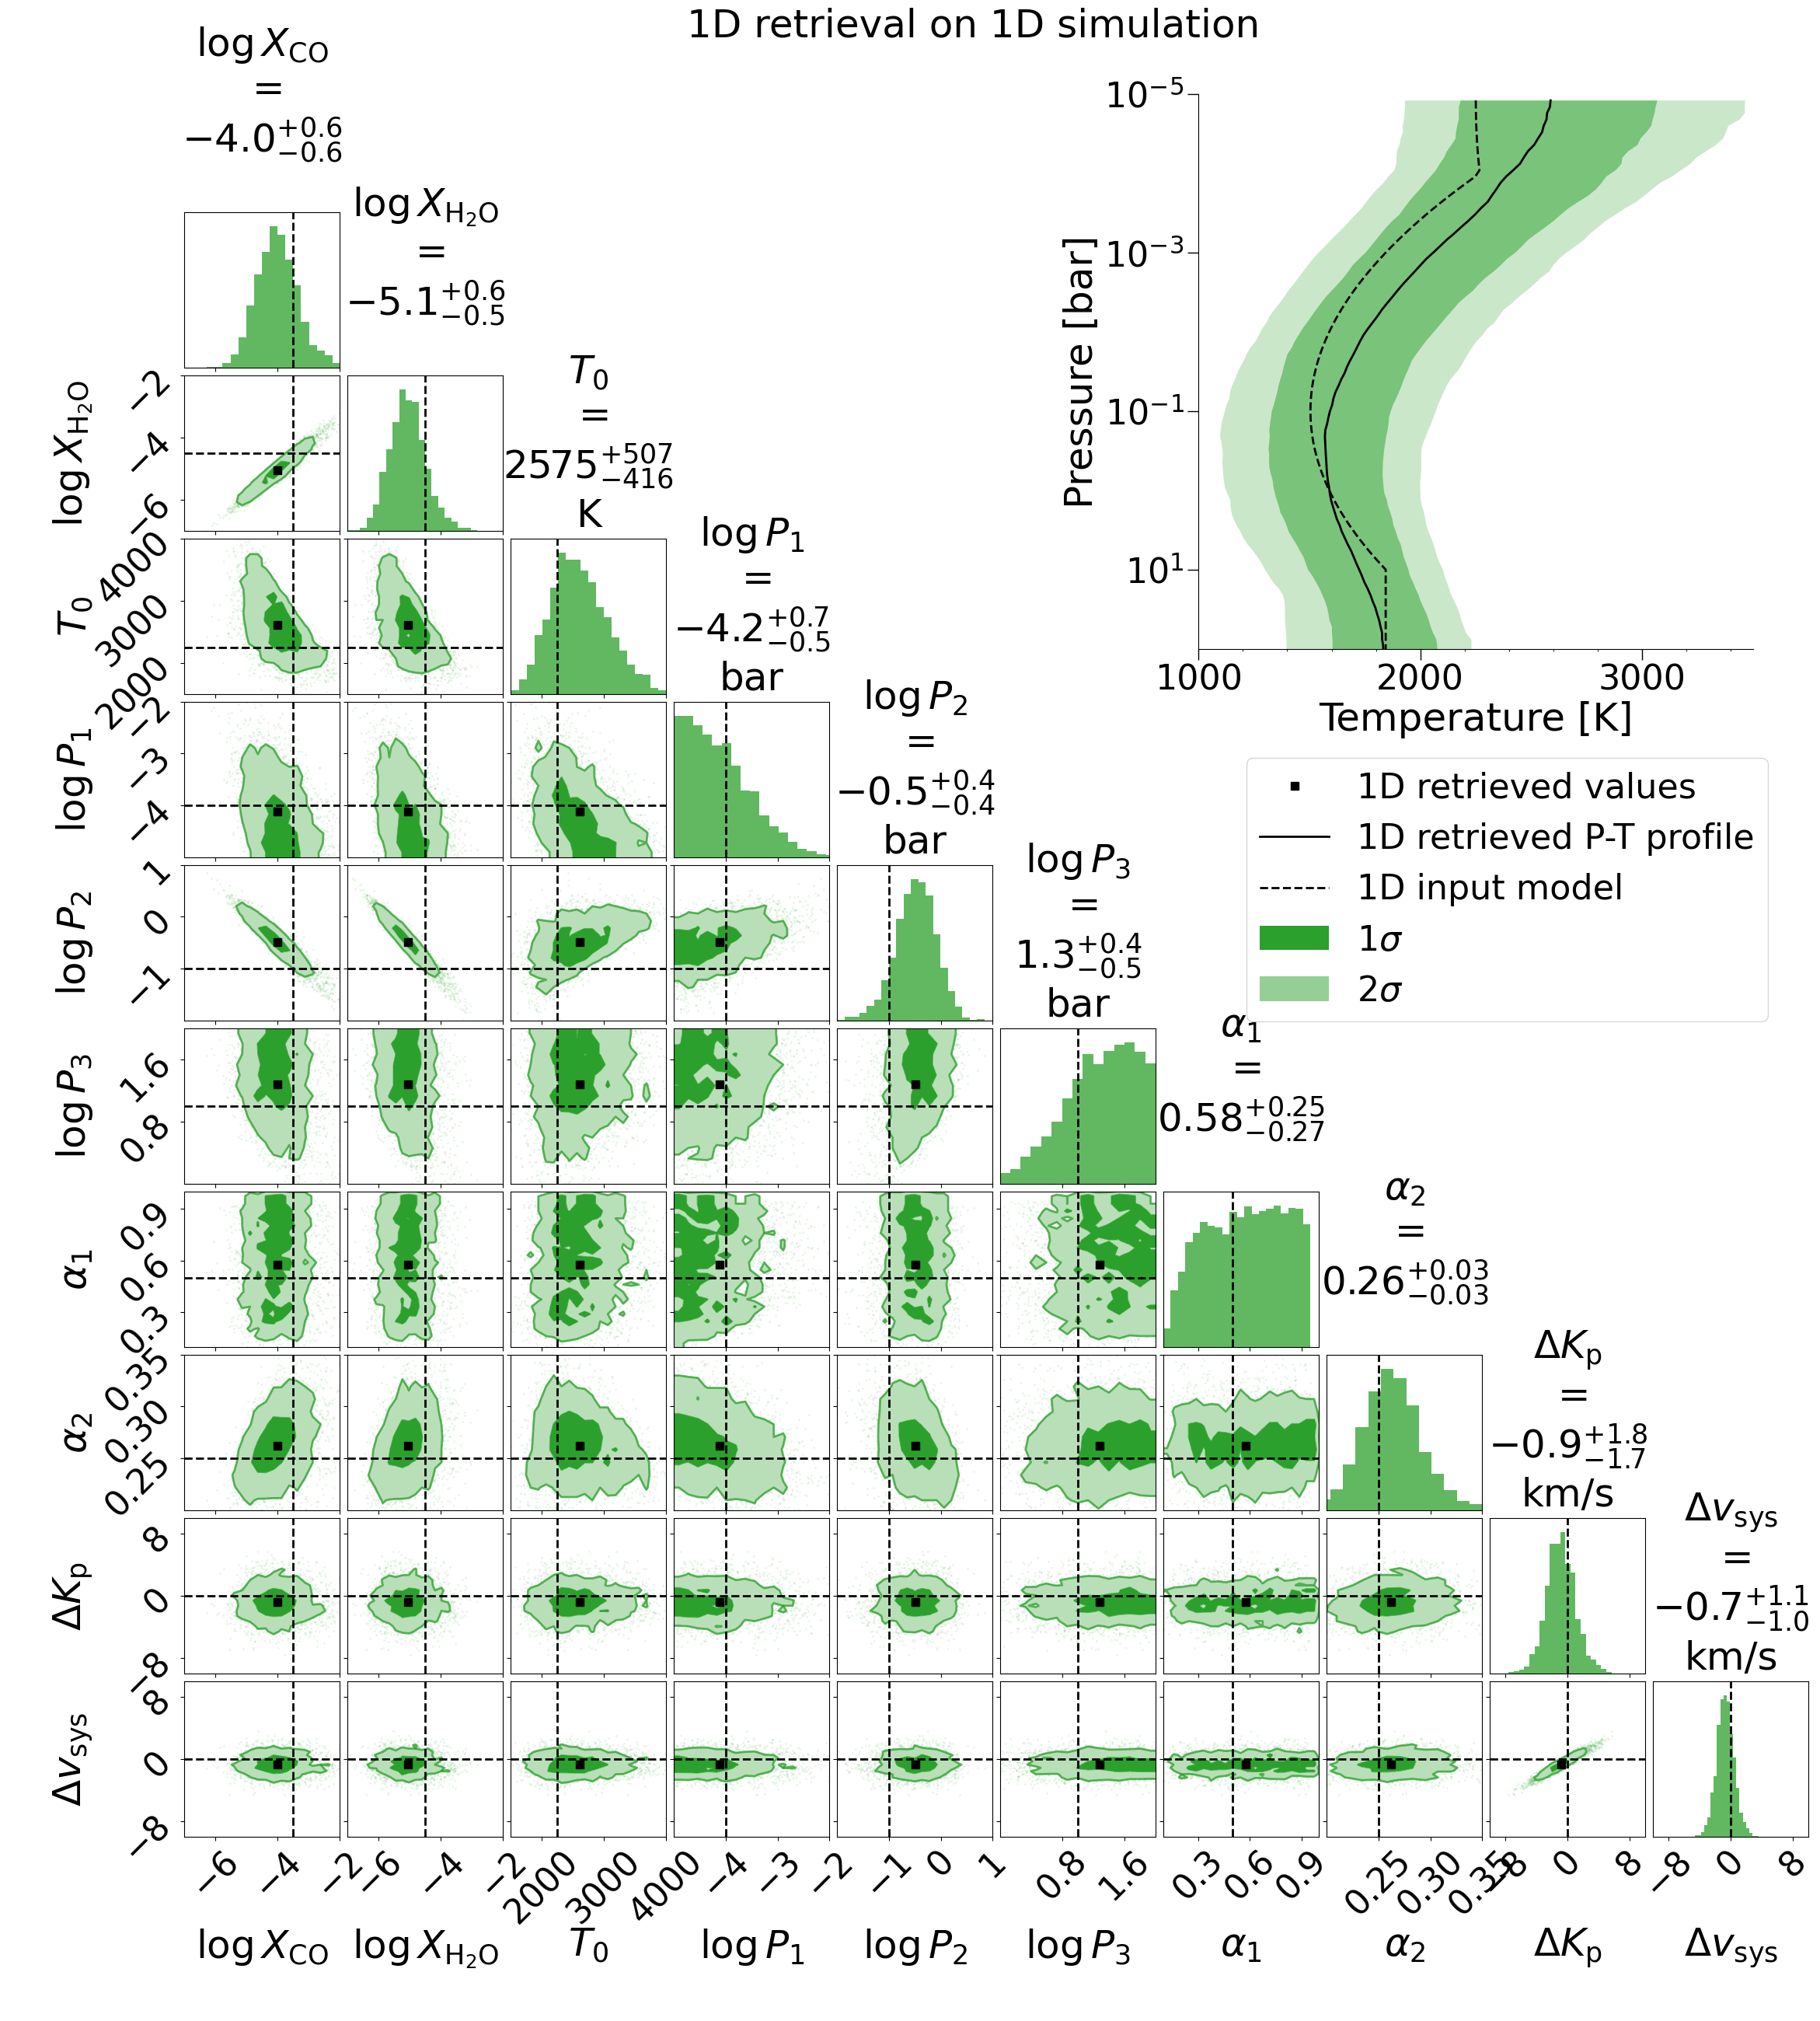

In [3]:
# Regular expression to match all decimal numbers positive or negative
pattern = r'[-+]?\d*\.\d+'

fig = None

levels = [1 - np.exp(-(sigma)**2/2) for sigma in sigma_levels]
samples = data[mask]
fig = corner.corner(samples, labels=labels,
                       quantiles=[],
                       show_titles=True, color=color, label_kwargs={'fontsize':labelsize}, title_kwargs={'fontsize':labelsize},
                      fill_contours=True, plot_density=False, plot_contours=True, plot_points=True,
                    contour_kwargs={'linewidths':2, 'alpha':0.75},
                      hist_kwargs={'lw':2, 'histtype':'stepfilled',
                                   'alpha':0.75},fig=fig, levels=levels)

# This is the empirical mean of the sample:
mean_values = np.mean(data[mask], axis=0)

# Extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

for i in range(ndim):
    text = axes[i,i].get_title().strip('\n')
    s = text[text.rfind('=')+1:]
    matches = np.array(re.findall(pattern, s), dtype='float')
    precision = params_precision[params[i]]
    values = r"${" + "{:.{}f}".format(np.round(matches[0], precision), precision) + "}_" + \
    "{" + "{:.{}f}".format(np.round(matches[1], precision), precision) + "}^" + \
    "{+" + "{:.{}f}".format(np.round(matches[2], precision), precision) + "}$"
    
    axes[i,i].set_title('')
    t = text[:text.rfind('=')+1] + '\n' + values +'\n'+units[i]
    axes[i,i].annotate(t, xy=(0.5,1.075), xycoords='axes fraction', ha='center', size=labelsize, color='k')
    
for i in range(ndim):
    ax = axes[i, i]
    ax.set_xlim(plot_ranges[i][0], plot_ranges[i][1])
    ax.tick_params(labelsize=ticksize)
    ax.axvline(expected_values[i], color='black', ls='--', lw=2)
    ax.locator_params(axis='both', nbins=3)

# Loop over the marginal
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.set_xlim(plot_ranges[xi][0], plot_ranges[xi][1])
        ax.set_ylim(plot_ranges[yi][0], plot_ranges[yi][1])
        ax.tick_params(labelsize=ticksize)
        ax.axvline(expected_values[xi], color='black', ls='--', lw=2)
        ax.axhline(expected_values[yi], color='black', ls='--', lw=2)
        ax.plot(mean_values[xi], mean_values[yi], "sk", ms=7.5)
        ax.locator_params(axis='both', nbins=3)
        
ax_pt = fig.add_axes([0.63, 0.73, 0.32, 0.32])
ax_pt = plot_pt_profile(ax_pt)
ax_pt.set_ylim(10**2,10**-5)
ax_pt.set_xlim(1000,3500)

# Create the figure
legend_elements = [Line2D([0], [0], label='1D retrieved values', marker='s', markersize=7.5, color='k', ls=''),
                   Line2D([0], [0], label='1D retrieved P-T profile', color='k', lw=2),
                   Line2D([0], [0], label='1D input model', color='k', ls='--', lw=2),
                   Patch(facecolor='tab:green', alpha=1, label=r'1$\sigma$'),
                   Patch(facecolor='tab:green', alpha=0.5, label=r'$2\sigma$'),
                  ]
axes[4,6].legend(handles=legend_elements, bbox_to_anchor=(4., 1.8), fontsize=ticksize, frameon=True, prop={'size': ticksize})
        
plt.suptitle(r'1D retrieval on 1D simulation', size=labelsize, y=1.1)
dirout = '../figures/'
plt.savefig(os.path.join(dirout, f'Fig10_1D_corner_plot.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(dirout, f'Fig10_1D_corner_plot.png'), bbox_inches='tight', dpi=200)
plt.show()